In [1]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
import seaborn as sn

In [2]:
df = pd.read_csv('dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df.info()


/Users/domenico/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 181501 entries, 0 to 185763
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          181501 non-null  object 
 1   tourney_name        181501 non-null  object 
 2   surface             181354 non-null  object 
 3   draw_size           181501 non-null  float64
 4   tourney_level       181501 non-null  object 
 5   tourney_date        181501 non-null  object 
 6   match_num           181501 non-null  float64
 7   winner_id           181501 non-null  float64
 8   winner_entry        25298 non-null   object 
 9   winner_name         181501 non-null  object 
 10  winner_hand         181501 non-null  object 
 11  winner_ioc          181501 non-null  object 
 12  winner_age          178681 non-null  float64
 13  loser_id            181501 non-null  float64
 14  loser_entry         43307 non-null   object 
 15  loser_name          181501 non-nul

In [3]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'])
df['tourney_year'] = df['tourney_date'].dt.year

### functions

In [4]:
def create_new_colums(winner_attr, loser_attr, attr):
    col1=df[['winner_name',winner_attr]]
    col2=df[['loser_name',loser_attr]]
    col2.rename(columns={'loser_name': 'winner_name'}, inplace = True)
    col2.rename(columns={loser_attr: winner_attr}, inplace = True)
    name2 = col1.append(col2) 
    name2.rename(columns={'winner_name': 'name',winner_attr:attr}, inplace = True)
    name2.drop_duplicates(inplace=True)
    return name2


In [5]:
def create_df(series):
    tmp = pd.DataFrame(series)
    tmp.reset_index(inplace=True)
    return tmp

def count_occ(df, attr_to_count):
    tmp = df[attr_to_count].value_counts(dropna=False)
    tmp = create_df(tmp)
    return tmp

## Dataframe with Players profile

#### matches' number per player

In [6]:
#matches won per player
num_matches_won = count_occ(df, 'winner_name')
num_matches_won.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#matches loss per player
num_matches_loss = count_occ(df, 'loser_name')
num_matches_loss.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#total matches per player
num_matches = num_matches_won.append(num_matches_loss)
num_matches = num_matches.groupby(['name']).num_matches.sum()
num_matches = create_df(num_matches)
num_matches.set_axis(['name', 'num_matches'], axis=1, inplace=True)

#drop players with few matches
num_matches = num_matches[num_matches['num_matches'] > 3]

#add ratio
num_matches_won.set_axis(['name', 'num_matches_won'], axis=1, inplace=True) #rename attribute 'num_matches' to 'num_matches_won', otherwise we could have a conflict
num_matches = pd.merge(num_matches, num_matches_won, how = 'left', on = 'name')
num_matches['ratio'] = num_matches['num_matches_won']/num_matches['num_matches']
num_matches.fillna(0, inplace = True)

del num_matches['num_matches_won'] #reduntant column

#RENAME our database
player_profile = num_matches
player_profile

,name,num_matches,ratio
0,AALIYA EBRAHIM,9,0.222222
1,AALYKA EBRAHIM,4,0.000000
2,AANU AYEGBUSI,6,0.500000
3,AARON ADDISON,11,0.181818
4,AAYUSHI TANWAR,6,0.166667
...,...,...,...
5876,ZOZIYA KARDAVA,78,0.410256
5877,ZSOMBOR PIROS,81,0.543210
5878,ZUZANA BOHATOVA,6,0.000000
5879,ZUZANA PAVELEKOVA,4,0.500000


## Statistics of players during period

In [7]:
years=df['tourney_year'].dropna()
years=years.unique()
years.sort()

for year in years:
    num_matches_year = df[df['tourney_year']==year] #takes only matches of a year
    num_m_y = 'num_matches_'+str(year)
    
    #matches won per player
    num_matches_won = count_occ(num_matches_year, 'winner_name')
    num_matches_won.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #matches loss per player
    num_matches_loss = count_occ(num_matches_year, 'loser_name')
    num_matches_loss.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #total matches per player
    num_matches = num_matches_won.append(num_matches_loss)
    num_matches = num_matches.groupby(['name'])[num_m_y].sum()
    num_matches = create_df(num_matches)
    num_matches.set_axis(['name', num_m_y], axis=1, inplace=True)
    
    #add ratio
    num_matches_won.set_axis(['name', 'num_matches_won'], axis=1, inplace=True) #rename attribute 'num_matches' to 'num_matches_won', otherwise we could have a conflict
    num_matches = pd.merge(num_matches, num_matches_won, how = 'left', on = 'name')
    num_matches['ratio_'+str(year)] = num_matches['num_matches_won']/num_matches[num_m_y]
    num_matches.fillna(0, inplace = True)
    del num_matches['num_matches_won']
    
    #add to our player profile ratio and matches of current year
    player_profile = pd.merge(player_profile, num_matches, how = 'left', on = 'name')
    player_profile.fillna(0, inplace = True) #players with no matches during a year

player_profile
    

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000
5877,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667
5878,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000
5879,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000


## Player's Hand

In [8]:
df_hand=create_new_colums('winner_hand','loser_hand','hand')
#df_hand.at[180480, 'hand'] = 'R'#AGGIUSTARE QUESTA COSA
df_hand.drop_duplicates(inplace=True)

player_profile=pd.merge(player_profile, df_hand, how='left', on='name')
player_profile

/Users/domenico/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U


## Player's Gender

In [9]:
df_gender = create_new_colums('winner_gender','loser_gender','gender')
player_profile = pd.merge(player_profile, df_gender, how='left', on='name')
player_profile

/Users/domenico/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F


## Player's nationality

In [10]:
df_ioc = create_new_colums('winner_ioc','loser_ioc','ioc')
df_ioc.drop_duplicates(inplace=True)

player_profile = pd.merge(player_profile, df_ioc, how='left', on='name')
player_profile

/Users/domenico/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK


## ages of players 

In [11]:
df['winner_birth']=df['tourney_year']-df['winner_age']
df['loser_birth']=df['tourney_year']-df['loser_age']

#winner_bith
winner_birth=df.groupby(['winner_name']).winner_birth.min() #print(gg.groupby(['winner_name']).birth.min())
winner_birth = create_df(winner_birth)
winner_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#loser_birth
loser_birth = df.groupby(['loser_name']).loser_birth.min() #print(gg.groupby(['loser_name']).birth.min())
loser_birth = create_df(loser_birth)
loser_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#players_birth
name_birth = winner_birth.append(loser_birth)
name_birth.dropna(inplace=True)
name_birth.drop_duplicates(inplace=True)
name_birth = name_birth.groupby(name_birth['name']).birth.min()
name_birth = create_df(name_birth)

player_profile = pd.merge(player_profile, name_birth, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN


## height of players

In [12]:
df_ht=create_new_colums('winner_ht','loser_ht','ht')
df_ht.dropna(inplace=True)
df_ht.drop_duplicates(inplace=True)
df_ht = df_ht.groupby(['name']).ht.max() 

player_profile=pd.merge(player_profile, df_ht, how='left', on='name')
player_profile

#completare aggiungendo l'altezza media tramite le nazionalità dei giocatori

/Users/domenico/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000


### Minutes

In [13]:
#mean winner minutes
win_min =df.groupby('winner_name').minutes.mean()
win_min = create_df(win_min)
win_min.set_axis(['name', 'minutes'], axis=1, inplace=True)

#mean loser minutes
loser_min = df.groupby('loser_name').minutes.mean()
loser_min = create_df(loser_min)
loser_min.set_axis(['name', 'minutes'], axis=1, inplace=True)

#mean player minutes
player_min = win_min.append(loser_min)
player_min = player_min.groupby('name').minutes.mean()

#add to player profile
player_profile = pd.merge(player_profile, player_min, how='left', on='name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000


###### rapport ace/svpt 

è il rapporto tra gli ace fatti e il numero di "battute" effettuate durante un match

svpt = numero di battute totali = numero di prime battute (1stIN) + numero di seconde battute (secondo tentativo se sbagli il primo, questo attributo non viene fornito ma è ricavabile)

### Percentage ace

fare la percetuale rispetto a tutti i servizi fatti oppure rispetto solo al primo servizio? la prof consiglia rispetto al primo servizio. Online dicono che un ace al secondo servizio è raro

In [14]:
#table tot ace per player 
win_ace =df.groupby('winner_name').w_ace.sum()
win_ace = create_df(win_ace)
win_ace.set_axis(['name', 'ace'], axis=1, inplace=True)

loser_ace =df.groupby('loser_name').l_ace.sum()
loser_ace = create_df(loser_ace)
loser_ace.set_axis(['name', 'ace'], axis=1, inplace=True)

player_ace = win_ace.append(loser_ace)
player_ace = player_ace.groupby('name').ace.sum()

#table tot 1stIn per player
win_1stIn =df.groupby('winner_name').w_1stIn.sum()
win_1stIn= create_df(win_1stIn)
win_1stIn.set_axis(['name', 'p_1stIn'], axis=1, inplace=True)

loser_1stIn =df.groupby('loser_name').l_1stIn.sum()
loser_1stIn = create_df(loser_1stIn)
loser_1stIn.set_axis(['name', 'p_1stIn'], axis=1, inplace=True)

player_1stIn= win_1stIn.append(loser_1stIn)
player_1stIn = player_1stIn.groupby('name').p_1stIn.sum()


p = pd.merge(player_ace, player_1stIn, how = 'left', on = 'name')
p['perc_ace'] = round((p['ace'] / p['p_1stIn'])*100, 0)
del p['ace']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0


In [15]:
win_1stwon =df.groupby('winner_name').w_1stWon.sum()
win_1stwon = create_df(win_1stwon)
win_1stwon.set_axis(['name', 'p_1stwon'], axis=1, inplace=True)

loser_1stwon =df.groupby('loser_name').l_1stWon.sum()
loser_1stwon = create_df(loser_1stwon)
loser_1stwon.set_axis(['name', 'p_1stwon'], axis=1, inplace=True)

player_1stwon= win_1stwon.append(loser_1stwon)
player_1stwon = player_1stwon.groupby('name').p_1stwon.sum()

p = pd.merge(player_1stIn, player_1stwon, how = 'left', on = 'name')
p['_1stwon_1stIn'] = (p['p_1stwon'] / p['p_1stIn']) *100
del p['p_1stwon']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000


#### total_won_service / total_service

In [16]:
#total service
win_svpt =df.groupby('winner_name').w_svpt.sum()
win_svpt = create_df(win_svpt)
win_svpt.set_axis(['name', 'svpt'], axis=1, inplace=True)

loser_svpt =df.groupby('loser_name').l_svpt.sum()
loser_svpt = create_df(loser_svpt)
loser_svpt.set_axis(['name', 'svpt'], axis=1, inplace=True)

player_svpt= win_svpt.append(loser_svpt)
player_svpt = player_svpt.groupby('name').svpt.sum()

player_svpt

name
AADA INNA                 74.0
AALISHA ALEXIS           112.0
AALIYA EBRAHIM           581.0
AALIYAH HOHMANN          168.0
AALYKA EBRAHIM           260.0
                        ...   
ZUZANA ZALABSKA          217.0
ZUZANA ZLOCHOVA        14041.0
ZUZANNA BEDNARZ          130.0
ZUZANNA SZCZEPANSKA      181.0
ZVONIMIR ORESKOVIC        34.0
Name: svpt, Length: 10070, dtype: float64

In [17]:
#winner second service won
win_2ndwon =df.groupby('winner_name').w_2ndWon.sum()
win_2ndwon = create_df(win_2ndwon)
win_2ndwon.set_axis(['name', 'p_2ndwon'], axis=1, inplace=True)

#loser second service won
loser_2ndwon =df.groupby('loser_name').l_2ndWon.sum()
loser_2ndwon = create_df(loser_2ndwon)
loser_2ndwon.set_axis(['name', 'p_2ndwon'], axis=1, inplace=True)

#player second service won
player_2ndwon= win_2ndwon.append(loser_2ndwon)
player_2ndwon = player_2ndwon.groupby('name').p_2ndwon.sum()

player_2ndwon

name
AADA INNA                 0.0
AALISHA ALEXIS            0.0
AALIYA EBRAHIM            0.0
AALIYAH HOHMANN           0.0
AALYKA EBRAHIM            0.0
                        ...  
ZUZANA ZALABSKA           0.0
ZUZANA ZLOCHOVA        1746.0
ZUZANNA BEDNARZ           0.0
ZUZANNA SZCZEPANSKA       0.0
ZVONIMIR ORESKOVIC        3.0
Name: p_2ndwon, Length: 10070, dtype: float64

In [18]:
#total number of service won (1st won + 2nd won)
total_serv_won = pd.merge(player_1stwon, player_2ndwon, how = 'left', on = 'name')
total_serv_won['total_won'] = total_serv_won['p_1stwon'] + total_serv_won['p_2ndwon']
total_serv_won.drop(['p_1stwon', 'p_2ndwon'], axis=1, inplace=True)

#calculate ratio: total_serv_won / total_serve
tot = pd.merge(total_serv_won, player_svpt, how = 'left', on = 'name')
tot['serv_won_tot_seve'] = tot['total_won'] / tot['svpt']
tot.drop(['total_won', 'svpt'], axis=1, inplace=True)

player_profile = pd.merge(player_profile, tot, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000,0.000000
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000,0.000000
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884,0.589705
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000


### breakpoints
total number of breakpoints for each player

In [19]:
def sum_col(df, gb_attr, attr_to_count, n_gb_attr, n_attr_to_count):
    player =df.groupby(gb_attr)[attr_to_count].sum()
    player = create_df(player)
    player.set_axis([n_gb_attr, n_attr_to_count], axis=1, inplace=True)
    return player


In [20]:
#breakpoints faced
win_bpfaced = sum_col(df, 'winner_name', 'w_bpFaced', 'name', 'bpFaced')
loser_bpfaced = sum_col(df, 'loser_name', 'l_bpFaced', 'name', 'bpFaced')
player_bpfaced = win_bpfaced.append(loser_bpfaced)
player_bpfaced = player_bpfaced.groupby('name').bpFaced.sum()

player_profile = pd.merge(player_profile, player_bpfaced, how = 'left', on = 'name')

#breakpoints saved
win_bpsaved = sum_col(df, 'winner_name', 'w_bpSaved', 'name', 'bpsaved')
loser_bpsaved = sum_col(df, 'loser_name', 'l_bpSaved', 'name', 'bpsaved')
player_bpsaved = win_bpsaved.append(loser_bpsaved)
player_bpsaved = player_bpsaved.groupby('name').bpsaved.sum()

player_profile = pd.merge(player_profile, player_bpsaved, how = 'left', on = 'name')

player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000,0.000000,0.0,0.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884,0.589705,602.0,335.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,0.0,0.0
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,0.0,0.0


### perc_df and perc_df_2ndIn
percentage of double faults respect first serve and second serve

In [21]:
#double faults
win_df = sum_col(df, 'winner_name', 'w_df', 'name', 'df')
loser_df= sum_col(df, 'loser_name', 'l_df', 'name', 'df')
player_df = win_df.append(loser_df)
player_df = player_df.groupby('name').df.sum()

#% double faults
p = pd.merge(player_df, player_1stIn, how = 'left', on = 'name')
p['perc_df'] = round((p['df'] / p['p_1stIn'])*100, 0)
del p['df']
del p['p_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884,0.589705,602.0,335.0,6.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [22]:
#percetage of double faults respect to 2ndserve
player_2ndIn = pd.merge(player_svpt, player_1stIn, how = 'left', on = 'name')
player_2ndIn['p_2ndIn'] = player_2ndIn['svpt'] - player_2ndIn['p_1stIn']
player_2ndIn.reset_index(inplace = True)
del player_2ndIn['svpt'] 
del player_2ndIn['p_1stIn']

p = pd.merge(player_df, player_2ndIn, how = 'left', on = 'name')
p['perc_df_2ndIn'] = round((p['df'] / p['p_2ndIn'])*100, 0)
del p['df']
del p['p_2ndIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0,14.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884,0.589705,602.0,335.0,6.0,9.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


### perc_2ndwon
percentage of second won


In [23]:
player_perc2w = pd.merge(player_2ndwon, player_2ndIn, how = 'left', on = 'name')
player_perc2w['perc_2ndwon'] = round((player_perc2w['p_2ndwon'] / player_perc2w['p_2ndIn'])*100, 0)
del player_perc2w['p_2ndwon']
del player_perc2w['p_2ndIn']

player_profile = pd.merge(player_profile, player_perc2w, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0,14.0,48.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884,0.589705,602.0,335.0,6.0,9.0,50.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


### PtsSG and PtsLSG
points played per service game and
points lost per service game.
FORSE NON è FATTIBILE PERCHè NON SAPPIAMO IN QUALE SET FA IL PUNTO?

### perc_v_ace_
ace rate against the player

In [24]:
#ace against
win_v_ace = sum_col(df, 'winner_name', 'l_ace', 'name', 'v_ace')
loser_v_ace = sum_col(df, 'loser_name', 'w_ace', 'name', 'v_ace')

player_v_ace = win_v_ace.append(loser_v_ace)
player_v_ace = player_v_ace.groupby('name').v_ace.sum()
#player_v_ace.isin([0]).sum()

In [25]:
#1stIn against
win_v_1stIn = sum_col(df, 'winner_name', 'l_1stIn', 'name', 'v_1stIn')
loser_v_1stIn = sum_col(df, 'loser_name', 'w_1stIn', 'name', 'v_1stIn')

player_v_1stIn= win_v_1stIn.append(loser_v_1stIn)
player_v_1stIn = player_v_1stIn.groupby('name').v_1stIn.sum()

In [26]:
player_perc_v_ace = pd.merge(player_v_ace, player_v_1stIn, how = 'left', on = 'name')
player_perc_v_ace['perc_v_ace'] = round((player_perc_v_ace['v_ace'] / player_perc_v_ace['v_1stIn'])*100, 0)
del player_perc_v_ace['v_ace']
del player_perc_v_ace['v_1stIn']

player_profile = pd.merge(player_profile, player_perc_v_ace, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0,14.0,48.0,9.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884,0.589705,602.0,335.0,6.0,9.0,50.0,9.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### perc_v_df
Double faults rate against

In [27]:
win_v_df = sum_col(df, 'winner_name', 'l_df', 'name', 'v_df')
loser_v_df= sum_col(df, 'loser_name', 'w_df', 'name', 'v_df')
player_v_df = win_v_df.append(loser_v_df)
player_v_df = player_v_df.groupby('name').v_df.sum()
#% double faults
p = pd.merge(player_v_df, player_v_1stIn, how = 'left', on = 'name')
p['perc_v_df'] = round((p['v_df'] / p['v_1stIn'])*100, 0)
del p['v_df']
del p['v_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0,14.0,48.0,9.0,6.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884,0.589705,602.0,335.0,6.0,9.0,50.0,9.0,7.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### perc_v_1stwon
first serve return points won DALL'AVVERSARIO, NON è POSSIBILE CALCOLARLO PER IL GIOCATORE

In [28]:
win_v_1stwon = sum_col(df, 'winner_name', 'l_1stWon', 'name', 'v_1stwon')
loser_v_1stwon = sum_col(df, 'loser_name', 'w_1stWon', 'name', 'v_1stwon')
player_v_1stwon = win_v_1stwon.append(loser_v_1stwon)
player_v_1stwon = player_v_1stwon.groupby('name').v_1stwon.sum()

#% double faults
p = pd.merge(player_v_1stwon, player_v_1stIn, how = 'left', on = 'name')
p['perc_v_1stwon'] = round((p['v_1stwon'] / p['v_1stIn'])*100, 0)
del p['v_1stwon']
del p['v_1stIn']
player_profile = pd.merge(player_profile, p, how = 'left', on = 'name')
player_profile

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
0,AALIYA EBRAHIM,9,0.222222,0.0,0.000000,0.0,0.0000,0.0,0.000000,8.0,0.250000,1.0,0.000000,0.0,0.000000,R,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0
1,AALYKA EBRAHIM,4,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,4.0,0.000000,0.0,0.000000,0.0,0.000000,U,F,IND,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AANU AYEGBUSI,6,0.500000,0.0,0.000000,0.0,0.0000,1.0,0.000000,5.0,0.600000,0.0,0.000000,0.0,0.000000,U,F,NGR,NaN,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
3,AARON ADDISON,11,0.181818,6.0,0.333333,0.0,0.0000,1.0,0.000000,3.0,0.000000,1.0,0.000000,0.0,0.000000,R,M,AUS,1996.0,187.076923,86.694444,15.0,68.357488,0.587855,83.0,52.0,12.0,14.0,48.0,9.0,6.0,76.0
4,AAYUSHI TANWAR,6,0.166667,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.000000,1.0,0.000000,2.0,0.500000,U,F,IND,2000.0,172.137193,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,ZOZIYA KARDAVA,78,0.410256,2.0,0.000000,4.0,0.5000,6.0,0.833333,28.0,0.428571,18.0,0.333333,20.0,0.350000,U,F,RUS,2001.0,165.312500,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0
5878,ZSOMBOR PIROS,81,0.543210,0.0,0.000000,2.0,0.0000,45.0,0.600000,31.0,0.483871,0.0,0.000000,3.0,0.666667,R,M,HUN,1999.0,184.000000,98.469902,7.0,65.009884,0.589705,602.0,335.0,6.0,9.0,50.0,9.0,7.0,67.0
5879,ZUZANA BOHATOVA,6,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.000000,5.0,0.000000,0.0,0.000000,1.0,0.000000,U,F,CZE,NaN,175.785714,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5880,ZUZANA PAVELEKOVA,4,0.500000,0.0,0.000000,0.0,0.0000,0.0,0.000000,3.0,0.666667,1.0,0.000000,0.0,0.000000,U,F,SVK,NaN,172.500000,60.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### v_2ndwon
second serve return points won

### list tourney 


## Rapresent all dataset

In [29]:
player_profile.info()
p=player_profile

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5882 entries, 0 to 5881
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               5882 non-null   object 
 1   num_matches        5882 non-null   int64  
 2   ratio              5882 non-null   float64
 3   num_matches_2016   5882 non-null   float64
 4   ratio_2016         5882 non-null   float64
 5   num_matches_2017   5882 non-null   float64
 6   ratio_2017         5882 non-null   float64
 7   num_matches_2018   5882 non-null   float64
 8   ratio_2018         5882 non-null   float64
 9   num_matches_2019   5882 non-null   float64
 10  ratio_2019         5882 non-null   float64
 11  num_matches_2020   5882 non-null   float64
 12  ratio_2020         5882 non-null   float64
 13  num_matches_2021   5882 non-null   float64
 14  ratio_2021         5882 non-null   float64
 15  hand               5882 non-null   object 
 16  gender             5882 

### Players : Numerical Attribute

In [30]:
pl_num=p.copy()
pl_num=pl_num.drop(['name','hand','gender','ioc'],1)
pl_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5882 entries, 0 to 5881
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_matches        5882 non-null   int64  
 1   ratio              5882 non-null   float64
 2   num_matches_2016   5882 non-null   float64
 3   ratio_2016         5882 non-null   float64
 4   num_matches_2017   5882 non-null   float64
 5   ratio_2017         5882 non-null   float64
 6   num_matches_2018   5882 non-null   float64
 7   ratio_2018         5882 non-null   float64
 8   num_matches_2019   5882 non-null   float64
 9   ratio_2019         5882 non-null   float64
 10  num_matches_2020   5882 non-null   float64
 11  ratio_2020         5882 non-null   float64
 12  num_matches_2021   5882 non-null   float64
 13  ratio_2021         5882 non-null   float64
 14  birth              5169 non-null   float64
 15  ht                 5877 non-null   float64
 16  minutes            5882 

### Players : Categorical Attribute

In [31]:
pl_cat=pd.DataFrame()
pl_cat['name']=p.name
pl_cat['hand']=p.hand
pl_cat['gender']=p.gender
pl_cat['ioc']=p.ioc

pl_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5882 entries, 0 to 5881
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5882 non-null   object
 1   hand    5882 non-null   object
 2   gender  5882 non-null   object
 3   ioc     5882 non-null   object
dtypes: object(4)
memory usage: 229.8+ KB


## Data Statistics of the Players Dataset

### numerical attributes

In [32]:
pl_num.describe()

,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
count,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.00000,5882.000000,5882.000000,5169.000000,5877.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000,5882.000000
mean,60.554913,0.379785,11.343081,0.212985,10.993710,0.204576,11.289017,0.215567,14.210813,0.251977,5.023121,0.17477,7.695172,0.178491,1995.900754,175.826816,69.541980,3.120367,27.227086,0.243316,312.839510,170.631588,3.783407,5.918225,19.853791,3.837810,4.035702,32.844781
std,79.780166,0.186434,18.178954,0.251531,18.030802,0.249894,18.092390,0.253212,19.794672,0.258305,8.842294,0.25283,12.987826,0.247189,5.112286,7.295953,15.498963,4.927200,31.228239,0.277635,594.417507,329.760144,5.020686,7.543691,22.768817,4.832534,3.315689,27.563771
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1964.000000,157.000000,34.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1993.000000,172.137193,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000
50%,20.000000,0.410097,2.000000,0.000000,2.000000,0.000000,2.000000,0.000000,4.000000,0.222222,0.000000,0.00000,0.000000,0.000000,1997.000000,173.500000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,23.000000
75%,79.000000,0.518821,14.000000,0.461538,13.000000,0.452381,14.000000,0.464286,22.000000,0.500000,6.000000,0.40000,10.000000,0.400000,2000.000000,180.000000,78.761029,5.000000,63.156042,0.564668,279.750000,138.000000,7.000000,11.000000,46.000000,6.000000,7.000000,66.000000
max,374.000000,1.000000,89.000000,1.000000,89.000000,1.000000,90.000000,1.000000,104.000000,1.000000,58.000000,1.00000,89.000000,1.000000,2006.000000,198.000000,313.500000,35.000000,95.462890,0.949992,3834.000000,2358.000000,44.000000,55.000000,94.000000,33.000000,31.000000,170.000000


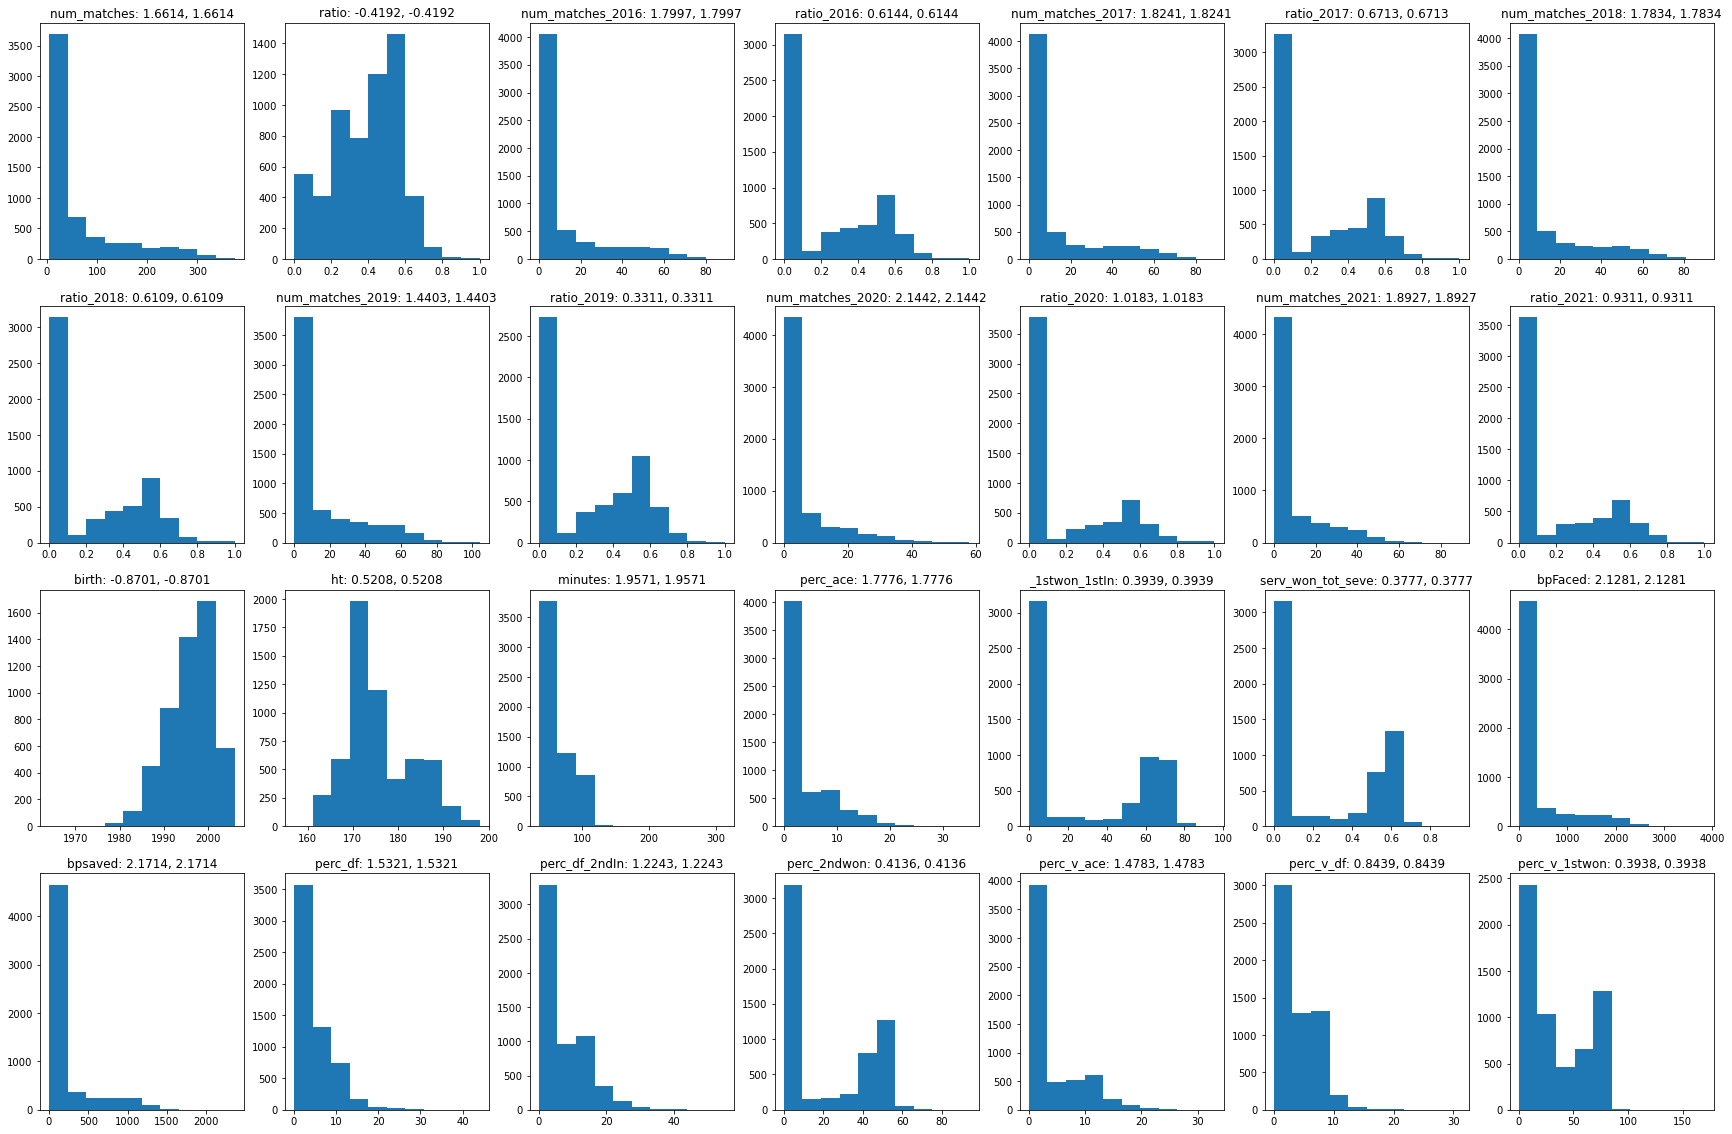

In [33]:
f, axs = plt.subplots(nrows = 4, ncols = 7, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/7)][i%7].hist(pl_num[pl_num.columns[i]])
    axs[int(i/7)][i%7].set_title(pl_num.columns[i] + ": " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()) + ", " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()))
plt.show()

### categorical attribute

In [34]:
print(pl_cat.gender.unique())

['F' 'M' 'U']


In [35]:
print(pl_cat.gender.value_counts())

F    4278
M    1599
U       5
Name: gender, dtype: int64


In [36]:
print(pl_cat[pl_cat.gender.isna()])

Empty DataFrame
Columns: [name, hand, gender, ioc]
Index: []


In [37]:
print(pl_cat.hand.value_counts())

U    3162
R    2410
L     310
Name: hand, dtype: int64


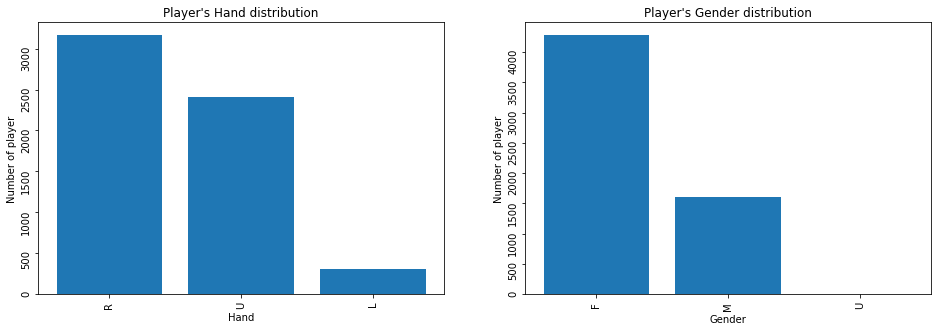

In [38]:
f, axs = plt.subplots(ncols=2, figsize=(16,5))
axs[0].bar(['R','U','L'],pl_cat.hand.value_counts())
axs[0].tick_params(labelrotation=90)
axs[0].set_title("Player's Hand distribution")
axs[0].set_xlabel("Hand")
axs[0].set_ylabel("Number of player")

axs[1].bar(sorted(pl_cat.gender.unique()),pl_cat.gender.value_counts())
axs[1].tick_params(labelrotation=90)
axs[1].set_title("Player's Gender distribution")
axs[1].set_xlabel("Gender")
axs[1].set_ylabel("Number of player")

plt.show() 

<AxesSubplot:title={'center':'Distribution of ioc'}, xlabel='ioc'>

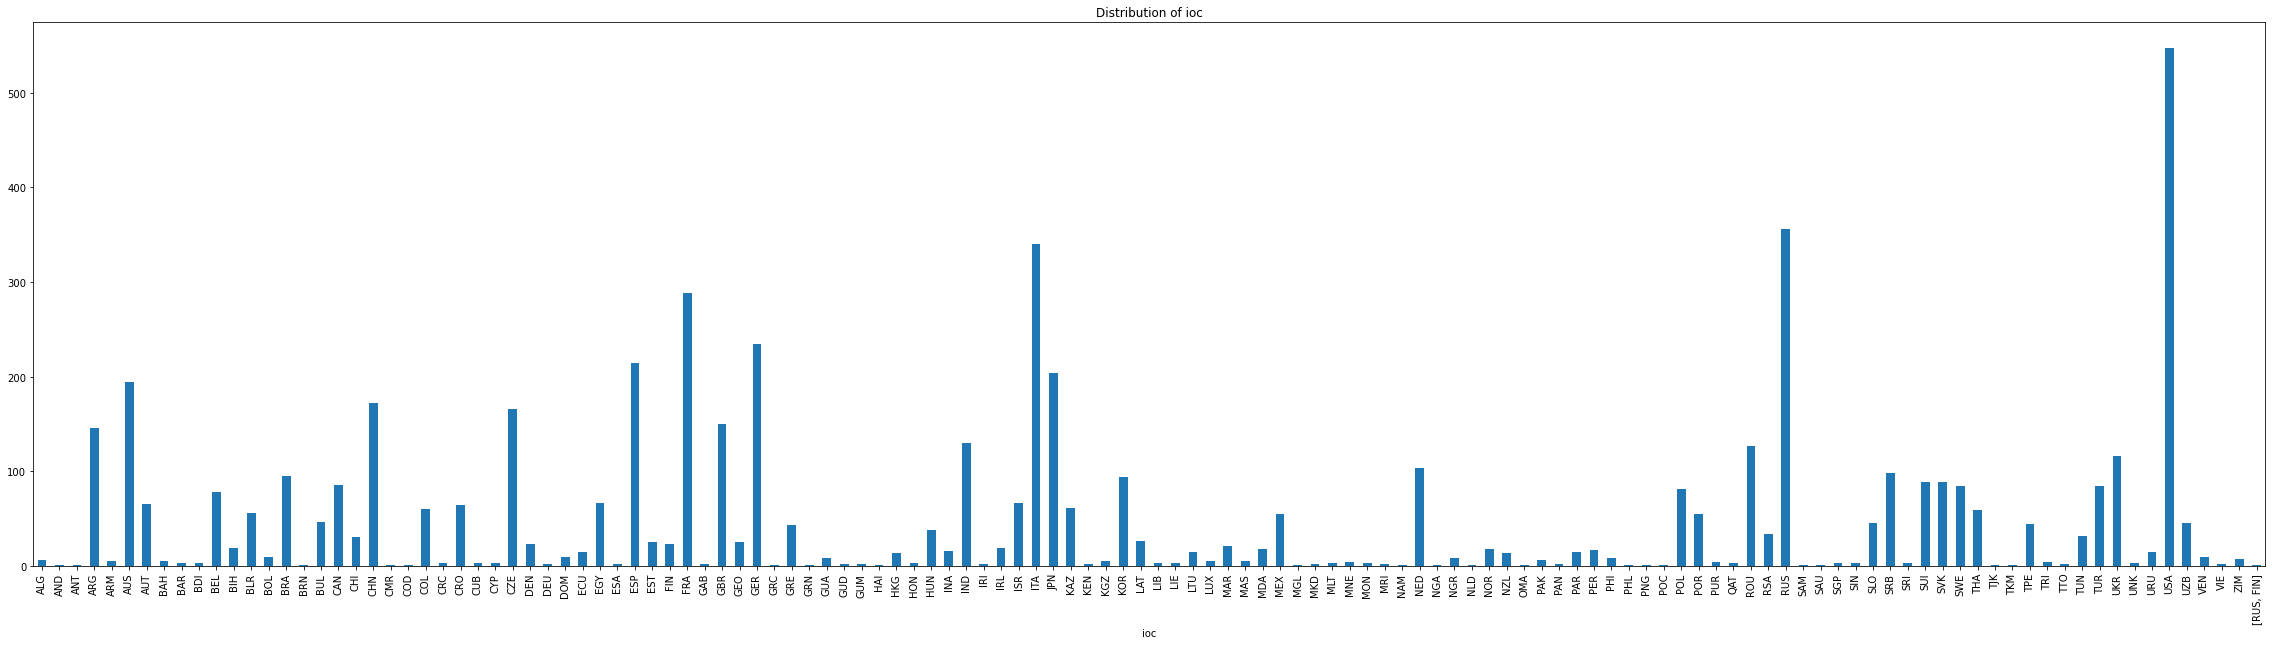

In [39]:
lf = pl_cat.groupby([pl_cat.ioc]).size()
lf.plot(
    figsize=(40, 10), 
    title="Distribution of ioc", 
    kind='bar')

<AxesSubplot:title={'center':'Distribution of ioc'}, xlabel='ioc'>

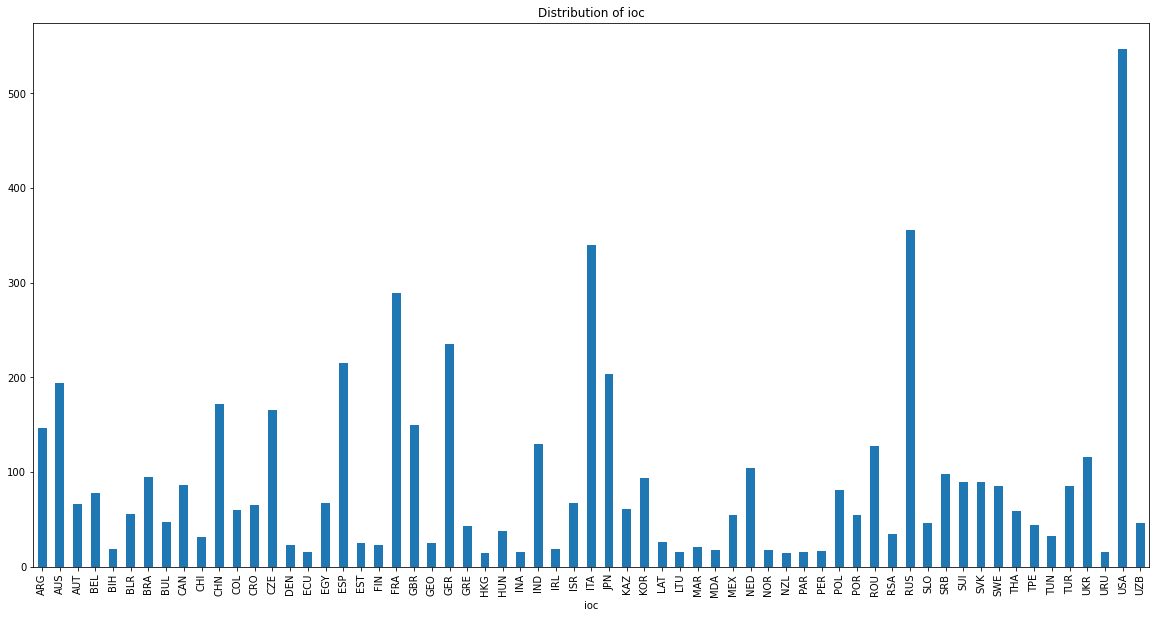

In [40]:
lf = pl_cat.groupby(pl_cat.ioc).size()
lf=lf[lf>10]
lf.plot(
    figsize=(20, 10), 
    title="Distribution of ioc", 
    kind='bar')



## outliers

In [41]:
pl_num.isna().sum()

num_matches            0
ratio                  0
num_matches_2016       0
ratio_2016             0
num_matches_2017       0
ratio_2017             0
num_matches_2018       0
ratio_2018             0
num_matches_2019       0
ratio_2019             0
num_matches_2020       0
ratio_2020             0
num_matches_2021       0
ratio_2021             0
birth                713
ht                     5
minutes                0
perc_ace               0
_1stwon_1stIn          0
serv_won_tot_seve      0
bpFaced                0
bpsaved                0
perc_df                0
perc_df_2ndIn          0
perc_2ndwon            0
perc_v_ace             0
perc_v_df              0
perc_v_1stwon          0
dtype: int64

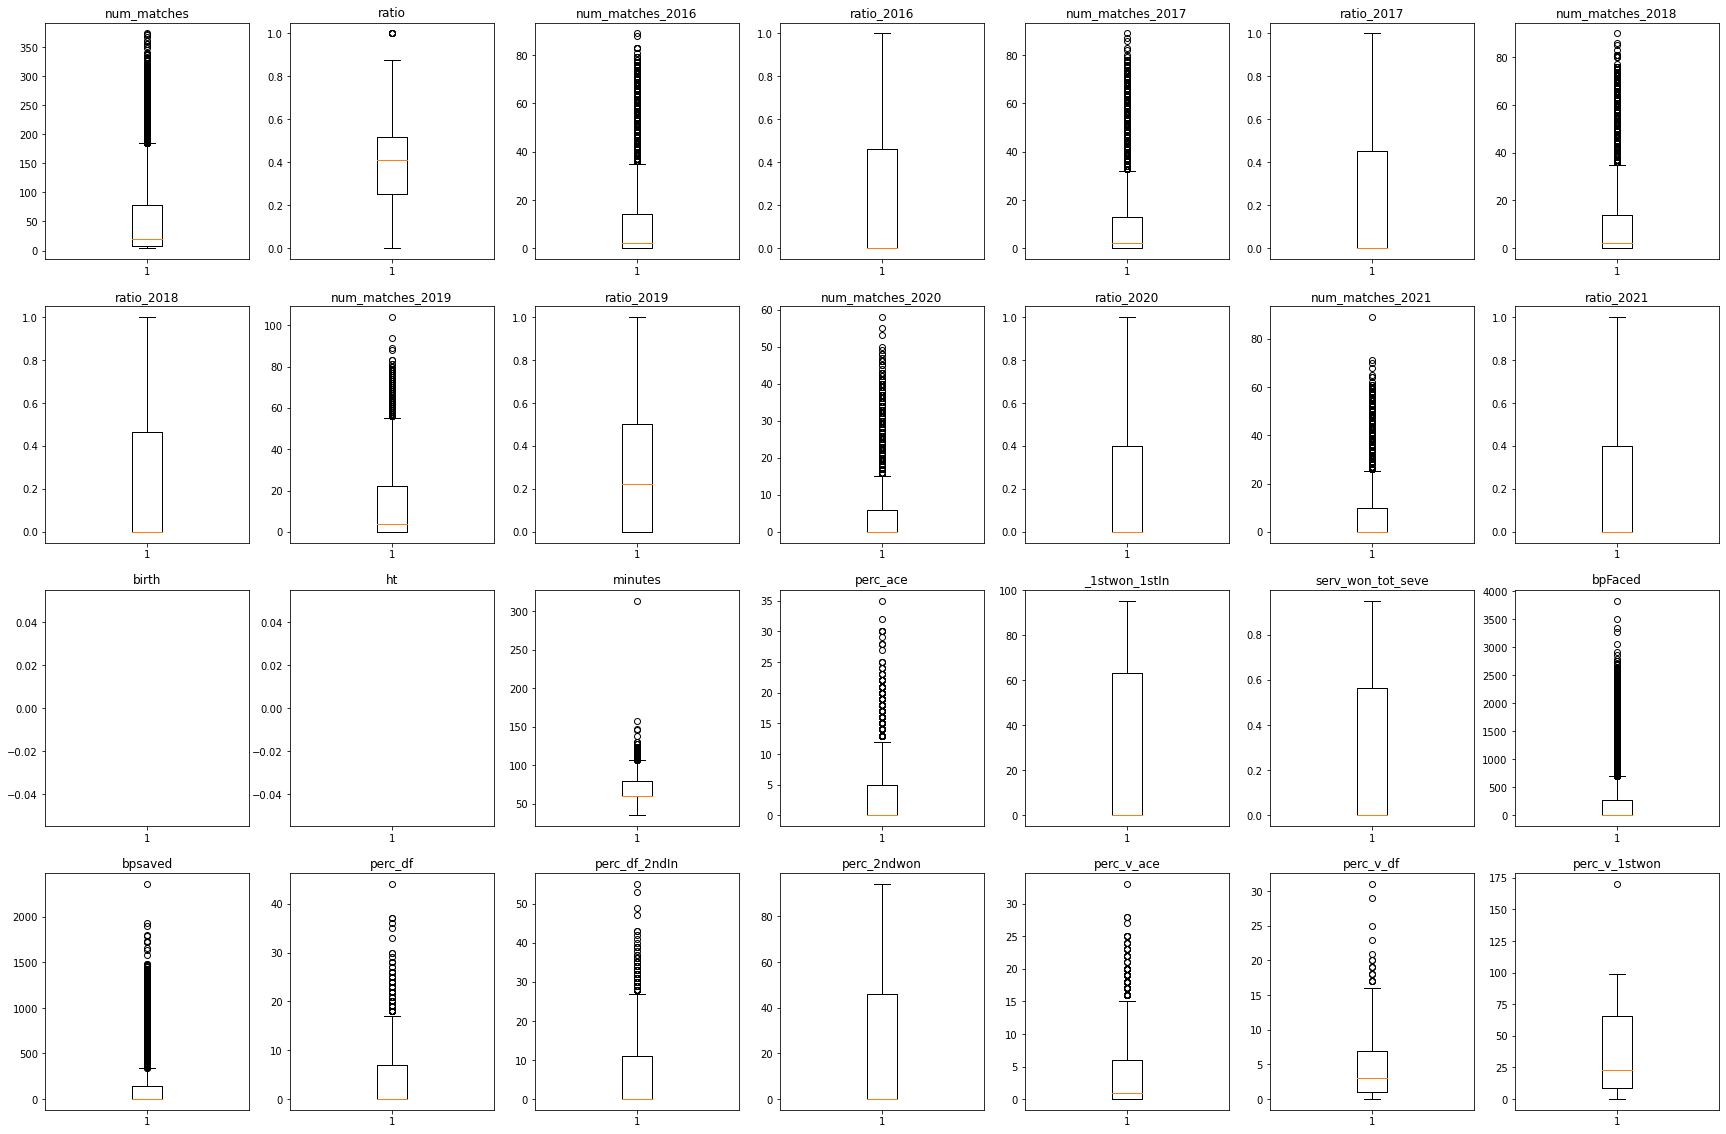

In [42]:
f, axs = plt.subplots(nrows = 4, ncols = 7, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/7)][i%7].boxplot(pl_num[pl_num.columns[i]])
    axs[int(i/7)][i%7].set_title(pl_num.columns[i])
plt.show()


## Missing Values

In [43]:
b_na=pl_num[pl_num.birth.isna()]
print(b_na.describe())

       num_matches       ratio  num_matches_2016  ratio_2016  \
count   713.000000  713.000000        713.000000  713.000000   
mean      9.713885    0.323447          0.065919    0.002899   
std       6.884239    0.196906          0.678628    0.043920   
min       4.000000    0.000000          0.000000    0.000000   
25%       5.000000    0.200000          0.000000    0.000000   
50%       7.000000    0.333333          0.000000    0.000000   
75%      12.000000    0.500000          0.000000    0.000000   
max      61.000000    0.875000         15.000000    1.000000   

       num_matches_2017  ratio_2017  num_matches_2018  ratio_2018  \
count        713.000000  713.000000        713.000000  713.000000   
mean           0.056101    0.001309          0.035063    0.001519   
std            0.534952    0.022793          0.300102    0.024344   
min            0.000000    0.000000          0.000000    0.000000   
25%            0.000000    0.000000          0.000000    0.000000   
50%      

In [44]:
b_na=pl_num[(pl_num.perc_ace==0) & (pl_num._1stwon_1stIn==0) & (pl_num.serv_won_tot_seve==0)& (pl_num.bpFaced==0)& (pl_num.bpsaved==0)
           & (pl_num.perc_df==0) & (pl_num.perc_df_2ndIn==0) & (pl_num.perc_2ndwon==0)]
print(b_na)

      num_matches     ratio  num_matches_2016  ratio_2016  num_matches_2017  \
0               9  0.222222               0.0         0.0               0.0   
1               4  0.000000               0.0         0.0               0.0   
2               6  0.500000               0.0         0.0               0.0   
4               6  0.166667               0.0         0.0               0.0   
7              12  0.583333              10.0         0.6               2.0   
...           ...       ...               ...         ...               ...   
5875           27  0.222222               0.0         0.0               0.0   
5876            7  0.285714               2.0         0.0               5.0   
5877           78  0.410256               2.0         0.0               4.0   
5879            6  0.000000               0.0         0.0               0.0   
5880            4  0.500000               0.0         0.0               0.0   

      ratio_2017  num_matches_2018  ratio_2018  num

In [45]:
player_profile.drop(b_na.index, inplace = True)
pl_num.drop(b_na.index, inplace = True)

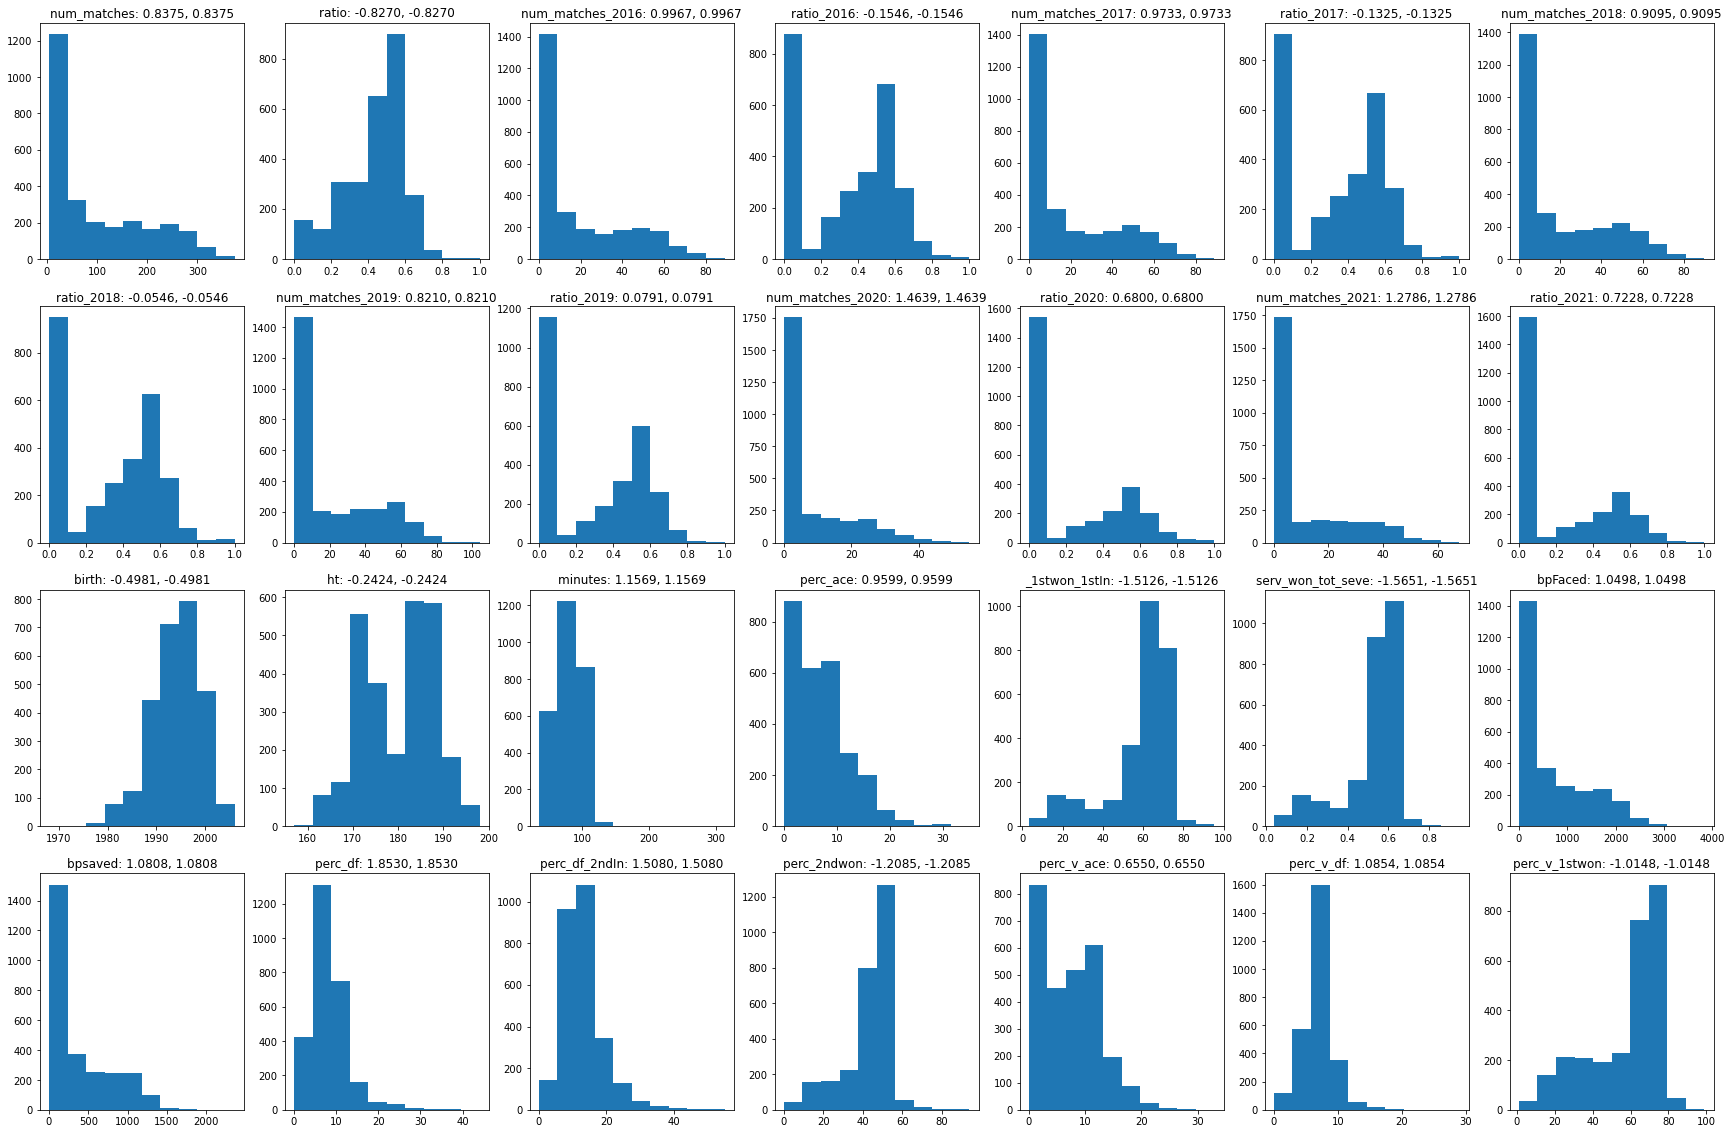

In [46]:
f, axs = plt.subplots(nrows = 4, ncols = 7, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/7)][i%7].hist(pl_num[pl_num.columns[i]])
    axs[int(i/7)][i%7].set_title(pl_num.columns[i] + ": " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()) + ", " + '{:.4f}'.format(pl_num[pl_num.columns[i]].skew()))
plt.show()

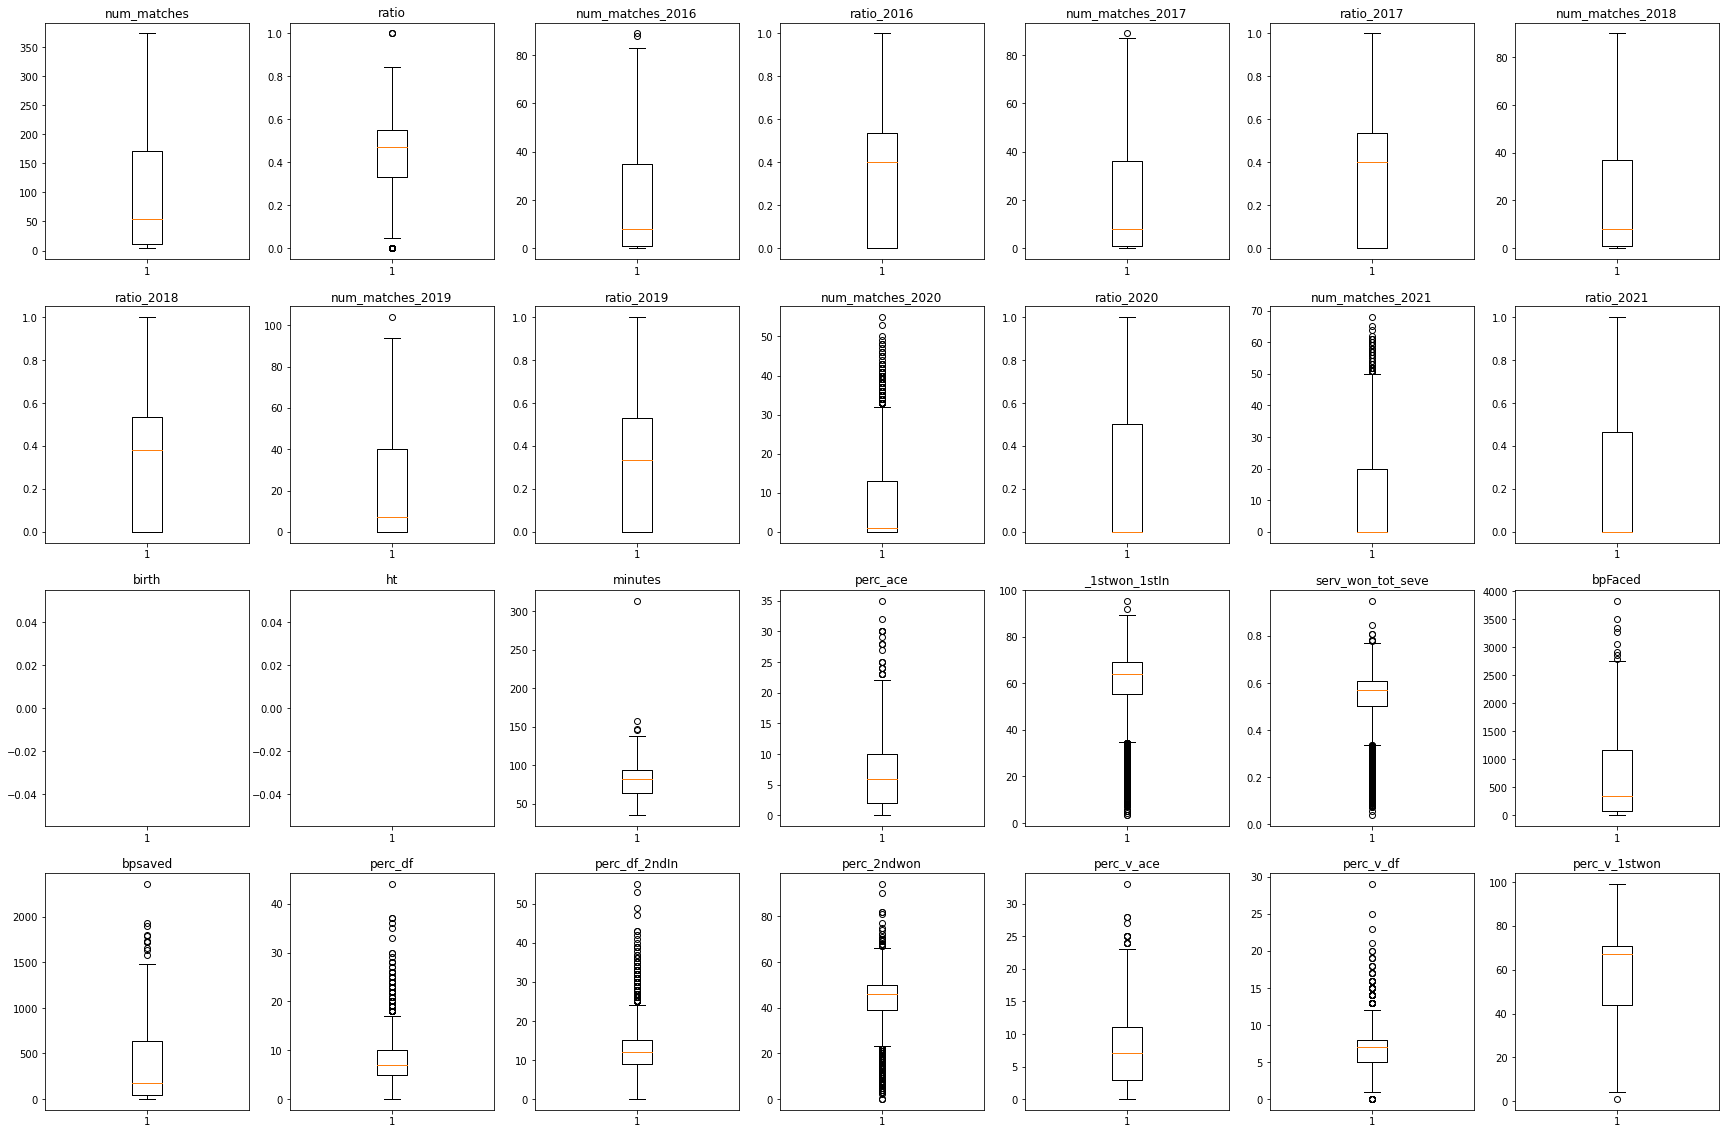

In [47]:
f, axs = plt.subplots(nrows = 4, ncols = 7, figsize=(30,20))

for i in range(len(pl_num.columns)):
    axs[int(i/7)][i%7].boxplot(pl_num[pl_num.columns[i]])
    axs[int(i/7)][i%7].set_title(pl_num.columns[i])
plt.show()



In [55]:
def detecting_outliers(attr):
    q1 = attr.quantile(0.25)
    q3 = attr.quantile(0.75)
    iqr = q3 - q1
    L = q1 - 2*iqr
    R = q3 + 2*iqr
    return L, R

In [56]:
def detecting_outliers_numerical(df, attr, substitute):
    print("BEFORE")
    #df.hist(attr) 
    plt.show()
    df.boxplot(attr) 
    plt.show()
    
    L, R = detecting_outliers(df[attr])
    print("L, R", L, R)
    if L < 0:
        L = 0

    df_outliers = df[(df[attr]< L) | (df[attr] > R)]
    new_df = df.drop(df_outliers.index)

    if substitute == 'median':
        median = df[attr].median()
        print("facciamo la mediana", median)
        df_outliers.loc[(df_outliers[attr] < L), attr] = median 
        df_outliers.loc[(df_outliers[attr] > R), attr] = median
    else:
        df_outliers.loc[(df_outliers[attr] < L), attr] = L
        df_outliers.loc[(df_outliers[attr] > R), attr] = R
    
    print("AFTER")
    new_df.append(df_outliers)
    #new_df[attr].plot.hist()
    plt.show()
    new_df[attr].plot.box()
    plt.show()
    
    return new_df 

In [57]:
L, R = detecting_outliers(pl_num.ratio)
outliers = player_profile[(player_profile.ratio > R) | (player_profile.ratio < L)]
outliers.num_matches.describe()



count     3.000000
mean      8.333333
std       5.773503
min       5.000000
25%       5.000000
50%       5.000000
75%      10.000000
max      15.000000
Name: num_matches, dtype: float64

In [58]:
#because of outlier players have few matches, drop it
player_profile.drop(outliers.index, inplace = True)

In [59]:
L, R = detecting_outliers(pl_num.minutes)
outliers = player_profile[(player_profile.minutes > R) | (player_profile.minutes < L)]
outliers.num_matches.describe()
outliers

,name,num_matches,ratio,num_matches_2016,ratio_2016,num_matches_2017,ratio_2017,num_matches_2018,ratio_2018,num_matches_2019,ratio_2019,num_matches_2020,ratio_2020,num_matches_2021,ratio_2021,hand,gender,ioc,birth,ht,minutes,perc_ace,_1stwon_1stIn,serv_won_tot_seve,bpFaced,bpsaved,perc_df,perc_df_2ndIn,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon
1118,CHENGZE LU,4,0.25,1.0,0.000000,3.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U,M,CHN,1999.0,183.666667,313.500000,9.0,63.235294,0.500000,30.0,13.0,12.0,16.0,32.0,14.0,5.0,69.0
5348,THIEN NGUYEN HOANG,4,0.25,3.0,0.333333,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,R,M,VIE,1995.0,185.676690,156.666667,9.0,65.811966,0.563063,54.0,29.0,12.0,14.0,46.0,9.0,11.0,70.0


In [60]:
player_profile.drop(outliers.index, inplace = True)

In [53]:
pl_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2737 entries, 3 to 5881
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_matches        2737 non-null   int64  
 1   ratio              2737 non-null   float64
 2   num_matches_2016   2737 non-null   float64
 3   ratio_2016         2737 non-null   float64
 4   num_matches_2017   2737 non-null   float64
 5   ratio_2017         2737 non-null   float64
 6   num_matches_2018   2737 non-null   float64
 7   ratio_2018         2737 non-null   float64
 8   num_matches_2019   2737 non-null   float64
 9   ratio_2019         2737 non-null   float64
 10  num_matches_2020   2737 non-null   float64
 11  ratio_2020         2737 non-null   float64
 12  num_matches_2021   2737 non-null   float64
 13  ratio_2021         2737 non-null   float64
 14  birth              2726 non-null   float64
 15  ht                 2735 non-null   float64
 16  minutes            2737 

### CORRELATION

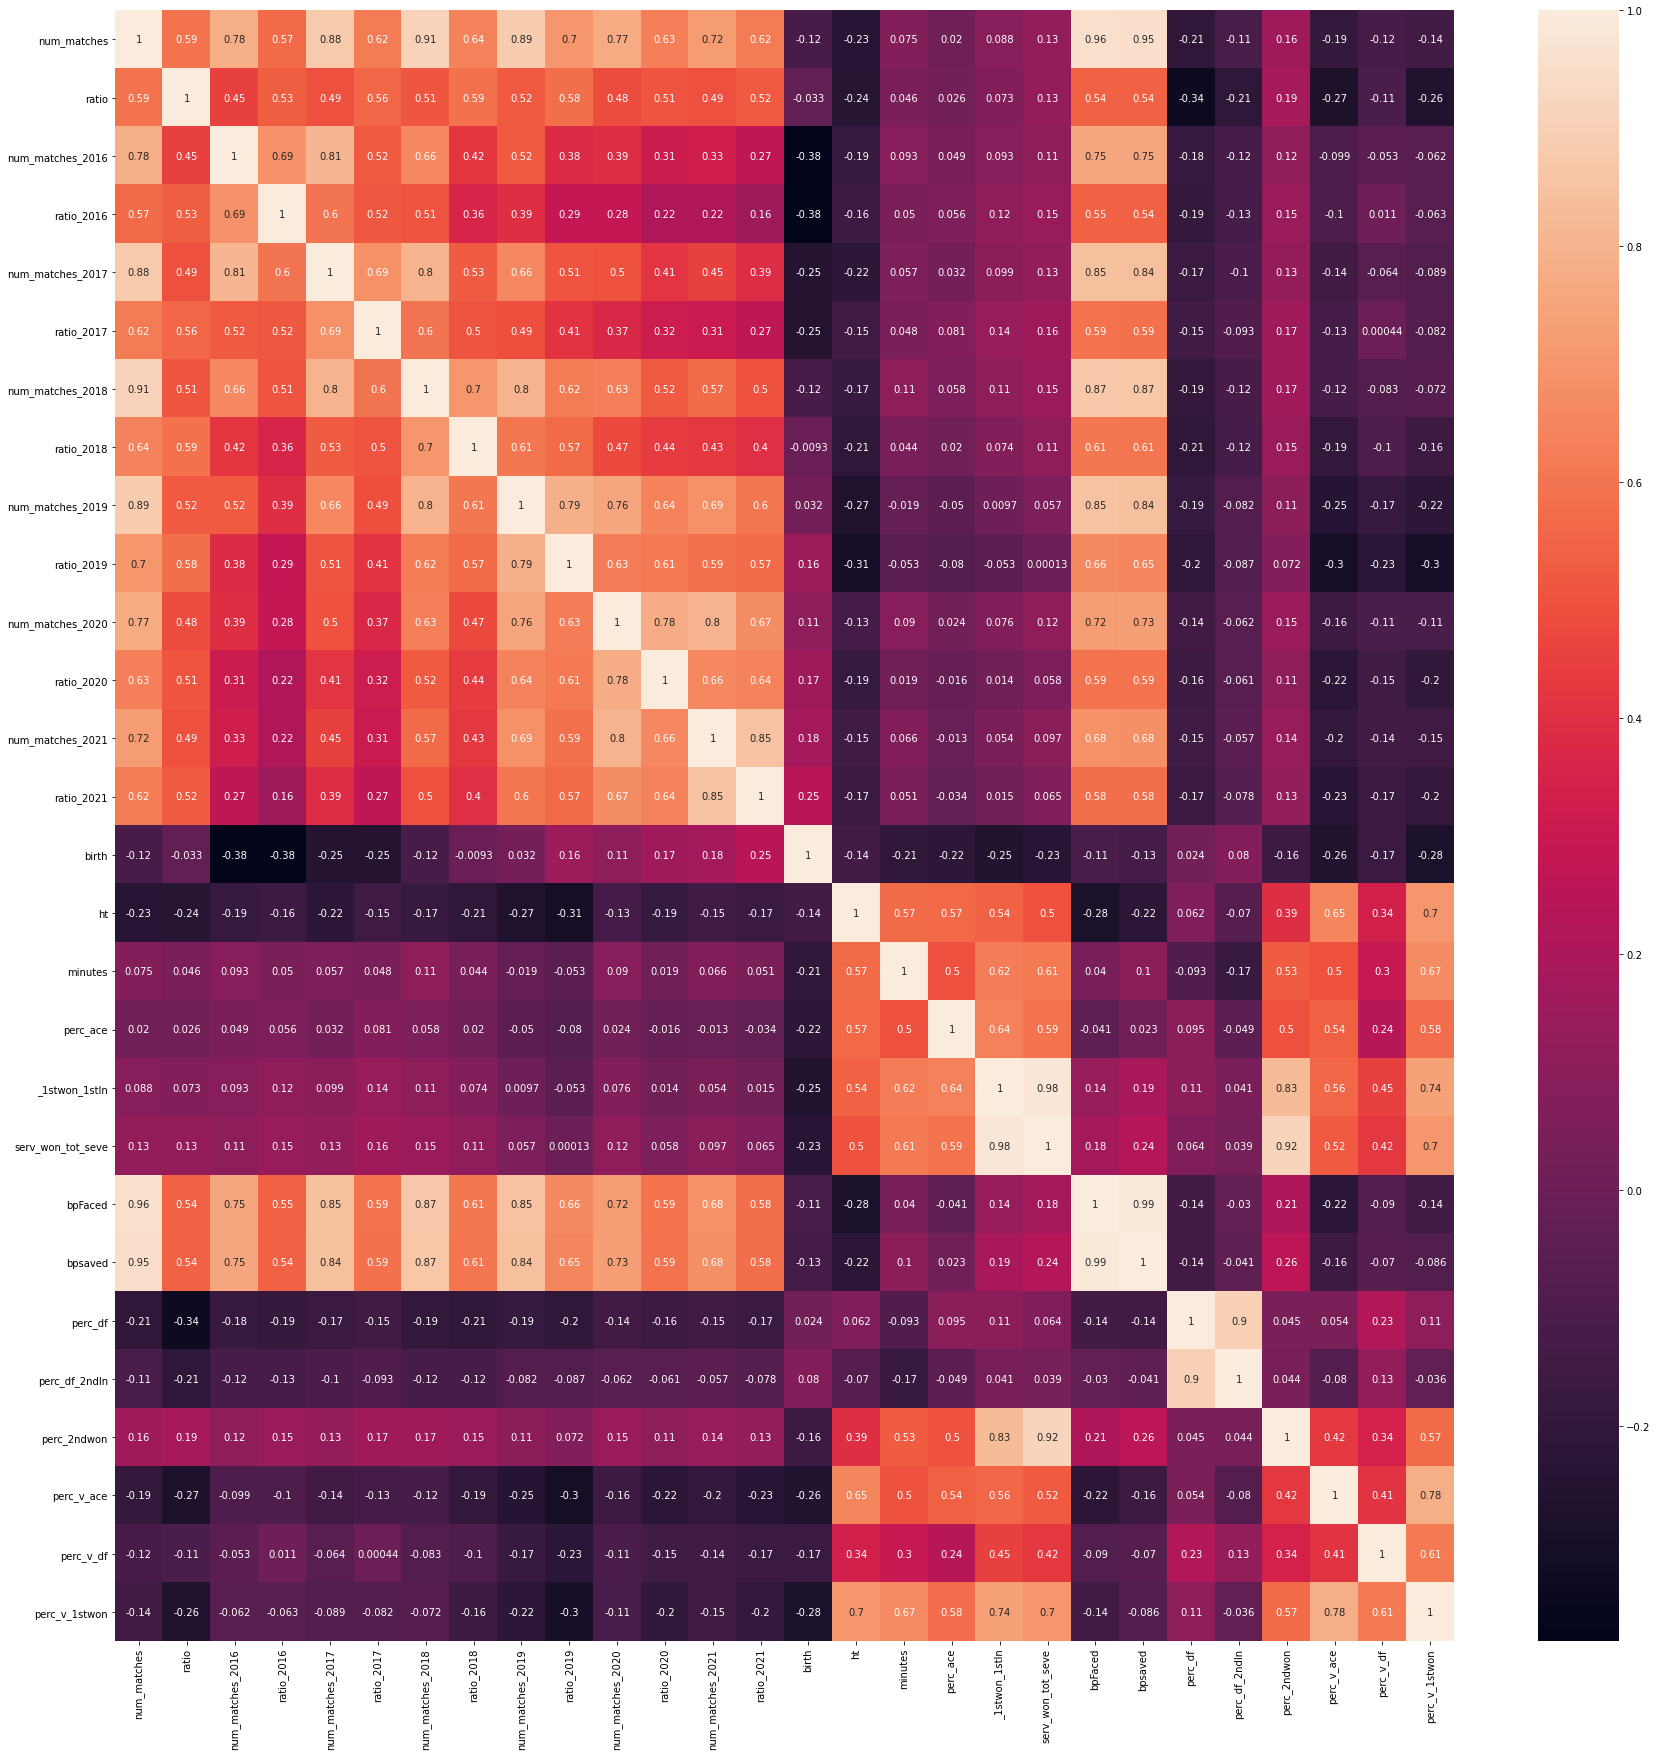

In [61]:
p = player_profile
#p = p.replace({0:np.nan})
matrix = p.corr()
fig, ax = plt.subplots(figsize=(30, 30)) #Sample figsize in inches
sn.heatmap(matrix, annot=True)
plt.show()

### manca correlation per valori alti e scrittura su csv